In [1]:
import pandas as pd
from scipy.stats import mannwhitneyu, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from statsmodels.sandbox.stats.multicomp import multipletests

sns.set('talk')
sns.set_style('whitegrid')

def p_adjust(pvalues, method='fdr_bh'):
    res = multipletests(pvalues, method=method)
    return np.array(res[1], dtype=float)

# Diversity assocations

## Read in data

In [2]:
nasal_meta = pd.read_csv('../data/metadata/nasal/nasal_metadata.csv', index_col='SampleID')
nasal_meta['age_at_collection'] = (pd.to_datetime(nasal_meta['CollectionDate']) - pd.to_datetime(nasal_meta['DOB'])).dt.days
nasal_meta = pd.concat([nasal_meta,
                        pd.read_csv('../data/nasal/otu_alpha_diversity.csv', index_col='SampleID'),
                        pd.read_csv('../data/nasal/otu_nmds_babies.csv', index_col='SampleID'),
                        pd.read_csv('../data/metadata/nasal/nasal_titers_yr2.csv', index_col='SampleID')],
                       axis=1)
nasal_meta['VR_group'] = nasal_meta['VR_group'].fillna('Not Measured')
nasal_meta = nasal_meta.dropna(subset=['VisitCode']) # this drops control samples since they don't have VisitCodes (e.g. MSA2002 and GD5)
nasal_meta.tail()

,SubmissionType,SampleNumber,SampleIDValidation,DiversigenCheckInSampleName,ReplacesLowVolumeSampleID,BoxLocation,SampleType,SampleSource,SequencingType,BabyN,...,median_mmNorm,median_mmNorm_DTAPHib,median_mmNorm_PCV,PT_protected,Dip_protected,FHA_protected,PRN_protected,TET_protected,PRP (Hib)_protected,VR_group
SampleID,,,,,,,,,,,,,,,,,,,,,
233_A2_NS_A2_Extra,Primary in Tube,1004.0,NaN,NaN,233_A2_NS_A1,Box 10_D8,Nasal Swab,Human Infant,16S,233.0,...,0.231020,0.213158,0.231020,True,True,True,True,True,True,NVR
107_V3_NS_A2,Primary in Tube,1005.0,NaN,NaN,107_V3_N!_A1,Box 10_D9,Nasal Swab,Human Infant,16S,107.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Measured
209_V4_NS_A2,Primary in Tube,1006.0,NaN,NaN,209_V4_NS_A1,Box 10_E1,Nasal Swab,Human Infant,16S,209.0,...,0.068419,0.035388,0.075616,True,True,False,True,True,True,NVR
107_V4_NS_2a,Primary in Tube,1007.0,NaN,NaN,NaN,Box9_E2,Nasal Swab,Human Infant,16S,107.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Measured
229_V2_NS_A1,Primary in Tube,1008.0,NaN,NaN,NaN,Box 10_C8,Nasal Swab,Human Infant,16S,229.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Not Measured


In [3]:
stool_nmds = pd.read_csv('../data/stool/kraken_nmds_babies.csv', index_col='SampleID')
stool_nmds.columns = ['kraken_' + i if i.startswith('MDS') else i for i in stool_nmds.columns]
stool_ko_nmds = pd.read_csv('../data/stool/ko_nmds_babies.csv', index_col='SampleID')
stool_ko_nmds.columns = ['ko_' + i if i.startswith('MDS') else i for i in stool_ko_nmds.columns]
stool_meta = pd.concat([pd.read_csv('../data/metadata/stool/stool_metadata.csv', index_col='SampleID'),
                        pd.read_csv('../data/stool/kraken_alpha_diversity.csv', index_col='SampleID'),
                        stool_nmds,
                        pd.read_csv('../data/stool/ko_alpha_diversity.csv', index_col='SampleID'),
                        stool_ko_nmds,
                        pd.read_csv('../data/metadata/stool/stool_titers_yr2.csv', index_col='SampleID')],
                       axis=1)
stool_meta = stool_meta.dropna(subset=['VisitCode'])
stool_meta = stool_meta.query('`gt_2.5`')
stool_meta.head()

,SubmissionType,SampleNumber,SampleIDValidation,DiversigenCheckInSampleName,BoxLocation,SampleType,SampleSource,SequencingType,BabyN,BabyN_checked,...,median_mmNorm,median_mmNorm_DTAPHib,median_mmNorm_PCV,PT_protected,Dip_protected,FHA_protected,PRN_protected,TET_protected,PRP (Hib)_protected,VR_group
SampleID,,,,,,,,,,,,,,,,,,,,,
204_V5,Primary in Tube,1.0,NaN,204_S,"Box 7, A1",Stool,Human Infant,MetaG,204.0,NaN,...,0.035342,0.027508,0.060708,False,True,False,True,True,True,NVR
226_V1,Primary in Tube,2.0,NaN,NaN,"Box 7, A2",Stool,Human Infant,MetaG,226.0,NaN,...,0.082202,0.097174,0.057712,True,True,True,True,True,True,NVR
107_V3,Primary in Tube,3.0,NaN,NaN,"Box 7, A3",Stool,Human Infant,MetaG,107.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
108_V3,Primary in Tube,4.0,NaN,NaN,"Box 7, A4",Stool,Human Infant,MetaG,108.0,NaN,...,0.168430,0.172291,0.164958,True,True,True,True,True,True,NVR
109_V1,Primary in Tube,5.0,NaN,NaN,"Box 7, A5",Stool,Human Infant,MetaG,109.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Nasal

In [4]:
nasal_titer_assoc_rows = list()
# for timepoint in ['V5', 'V6', 'V7', 'V9']:
for timepoint in set([i for i in nasal_meta['VisitCode'] if i.startswith('V')]):
    for div_metric in ['n_otus_div', 'simpson_e_div', 'shannon_div', 'MDS1', 'MDS2']:
        N_LVR = len(nasal_meta.query("VisitCode == @timepoint & VR_group == 'LVR'")[div_metric].dropna())
        N_NVR = len(nasal_meta.query("VisitCode == @timepoint & VR_group == 'NVR'")[div_metric].dropna())
        if N_LVR > 2 and N_NVR > 2:
            w_value, p_value = mannwhitneyu(nasal_meta.query("VisitCode == @timepoint & VR_group == 'LVR'")[div_metric].values,
                                            nasal_meta.query("VisitCode == @timepoint & VR_group == 'NVR'")[div_metric].values,
                                           nan_policy='omit')
            nasal_titer_assoc_rows.append([timepoint, div_metric, 'LVR/NVR', N_LVR, N_NVR, w_value, p_value])
nasal_titer_assocs = pd.DataFrame(nasal_titer_assoc_rows, columns=['timepoint', 'div_metric', 'titer_measure', 'N_LVR', 'N_NVR', 'stat', 'p_value']).sort_values('p_value')
nasal_titer_assocs.head()

,timepoint,div_metric,titer_measure,N_LVR,N_NVR,stat,p_value


In [5]:
nasal_titer_correls_rows = list()
# for timepoint in ['V5', 'V6', 'V7', 'V9']:
for timepoint in set([i for i in nasal_meta['VisitCode'] if i.startswith('V')]):
    for div_metric in ['n_otus_div', 'simpson_e_div', 'shannon_div', 'MDS1', 'MDS2']:
        for titer_measure in ['median_mmNorm', 'median_mmNorm_DTAPHib', 'median_mmNorm_PCV']:
            N = len(nasal_meta.query("VisitCode == @timepoint")[titer_measure].dropna())
            if N > 3:
                r_value, p_value = spearmanr(nasal_meta.query("VisitCode == @timepoint")[div_metric].values,
                                             nasal_meta.query("VisitCode == @timepoint")[titer_measure].values,
                                             nan_policy='omit')
                nasal_titer_correls_rows.append([timepoint, div_metric, titer_measure, N, r_value, p_value])
nasal_titer_correls = pd.DataFrame(nasal_titer_correls_rows, columns=['timepoint', 'div_metric', 'titer_measure', 'N', 'R', 'p_value']).sort_values('p_value')
nasal_titer_correls.head()

,timepoint,div_metric,titer_measure,N,R,p_value
145,V8,MDS1,median_mmNorm_DTAPHib,50,0.454801,0.000906
95,V9,simpson_e_div,median_mmNorm_PCV,55,-0.387002,0.003841
144,V8,MDS1,median_mmNorm,50,0.329268,0.019548
93,V9,simpson_e_div,median_mmNorm,55,-0.313894,0.020810
129,V6,MDS1,median_mmNorm,52,0.293825,0.045005


In [6]:
nasal_col_order = ['body_site', 'timepoint', 'div_metric', 'titer_measure', 'N_LVR', 'N_NVR', 'N', 'stat', 'R', 'p_value']
nasal_titer_stats = pd.concat([nasal_titer_assocs, nasal_titer_correls]).sort_values('p_value')
nasal_titer_stats['body_site'] = 'nasal'
nasal_titer_stats = nasal_titer_stats[nasal_col_order]
nasal_titer_stats.head()

,body_site,timepoint,div_metric,titer_measure,N_LVR,N_NVR,N,stat,R,p_value
145,nasal,V8,MDS1,median_mmNorm_DTAPHib,NaN,NaN,50.0,NaN,0.454801,0.000906
95,nasal,V9,simpson_e_div,median_mmNorm_PCV,NaN,NaN,55.0,NaN,-0.387002,0.003841
144,nasal,V8,MDS1,median_mmNorm,NaN,NaN,50.0,NaN,0.329268,0.019548
93,nasal,V9,simpson_e_div,median_mmNorm,NaN,NaN,55.0,NaN,-0.313894,0.02081
129,nasal,V6,MDS1,median_mmNorm,NaN,NaN,52.0,NaN,0.293825,0.045005


In [7]:
nasal_titer_stats.query('p_value < .05')

,body_site,timepoint,div_metric,titer_measure,N_LVR,N_NVR,N,stat,R,p_value
145,nasal,V8,MDS1,median_mmNorm_DTAPHib,NaN,NaN,50.0,NaN,0.454801,0.000906
95,nasal,V9,simpson_e_div,median_mmNorm_PCV,NaN,NaN,55.0,NaN,-0.387002,0.003841
144,nasal,V8,MDS1,median_mmNorm,NaN,NaN,50.0,NaN,0.329268,0.019548
93,nasal,V9,simpson_e_div,median_mmNorm,NaN,NaN,55.0,NaN,-0.313894,0.02081
129,nasal,V6,MDS1,median_mmNorm,NaN,NaN,52.0,NaN,0.293825,0.045005


## Stool

In [8]:
stool_titer_assoc_rows = list()
# for timepoint in ['V5', 'V6', 'V7', 'V9']:
for timepoint in set([i for i in stool_meta['VisitCode'] if i.startswith('V')]):
    for div_metric in ['genus_richness', 'genus_evenness', 'genus_shannon', 'ko_richness', 'ko_evenness', 'ko_shannon', 'kraken_MDS1', 'kraken_MDS2', 'ko_MDS1', 'ko_MDS2']:
        N_LVR = len(stool_meta.query("VisitCode == @timepoint & VR_group == 'LVR'")[div_metric].dropna())
        N_NVR = len(stool_meta.query("VisitCode == @timepoint & VR_group == 'NVR'")[div_metric].dropna())
        if N_LVR > 2 and N_NVR > 2:
            w_value, p_value = mannwhitneyu(stool_meta.query("VisitCode == @timepoint & VR_group == 'LVR'")[div_metric].values,
                                            stool_meta.query("VisitCode == @timepoint & VR_group == 'NVR'")[div_metric].values,
                                            nan_policy='omit')
            stool_titer_assoc_rows.append([timepoint, div_metric, 'LVR/NVR', N_LVR, N_NVR, w_value, p_value])
stool_titer_assocs = pd.DataFrame(stool_titer_assoc_rows, columns=['timepoint', 'div_metric', 'titer_measure', 'N_LVR', 'N_NVR', 'stat', 'p_value']).sort_values('p_value')
stool_titer_assocs.head()

,timepoint,div_metric,titer_measure,N_LVR,N_NVR,stat,p_value


In [9]:
stool_titer_correls_rows = list()
# for timepoint in ['V5', 'V6', 'V7', 'V9']:
for timepoint in set([i for i in stool_meta['VisitCode'] if i.startswith('V')]):
    for div_metric in ['genus_richness', 'genus_evenness', 'genus_shannon', 'ko_richness', 'ko_evenness', 'ko_shannon', 'kraken_MDS1', 'kraken_MDS2', 'ko_MDS1', 'ko_MDS2']:
        for titer_measure in ['median_mmNorm', 'median_mmNorm_DTAPHib', 'median_mmNorm_PCV']:
            N = len(stool_meta.query("VisitCode == @timepoint")[titer_measure].dropna())
            if N > 3:
                r_value, p_value = spearmanr(stool_meta.query("VisitCode == @timepoint")[div_metric].values,
                                             stool_meta.query("VisitCode == @timepoint")[titer_measure].values,
                                             nan_policy='omit')
                stool_titer_correls_rows.append([timepoint, div_metric, titer_measure, N, r_value, p_value])
stool_titer_correls = pd.DataFrame(stool_titer_correls_rows, columns=['timepoint', 'div_metric', 'titer_measure', 'N', 'R', 'p_value']).sort_values('p_value')
stool_titer_correls.head()

,timepoint,div_metric,titer_measure,N,R,p_value
341,V3,ko_richness,median_mmNorm_PCV,20,-0.556600,0.010806
303,V2,genus_evenness,median_mmNorm,26,-0.478974,0.013302
339,V3,ko_richness,median_mmNorm,20,-0.522001,0.018233
328,V2,ko_MDS2,median_mmNorm_DTAPHib,26,-0.459145,0.018299
150,V4,genus_richness,median_mmNorm,14,0.604396,0.022057


In [10]:
stool_col_order = ['body_site', 'timepoint', 'div_metric', 'titer_measure', 'N_LVR', 'N_NVR', 'N', 'stat', 'R', 'p_value']
stool_titer_stats = pd.concat([stool_titer_assocs, stool_titer_correls]).sort_values('p_value')
stool_titer_stats['body_site'] = 'stool'
stool_titer_stats = stool_titer_stats[stool_col_order]
stool_titer_stats.head()

,body_site,timepoint,div_metric,titer_measure,N_LVR,N_NVR,N,stat,R,p_value
341,stool,V3,ko_richness,median_mmNorm_PCV,NaN,NaN,20.0,NaN,-0.556600,0.010806
303,stool,V2,genus_evenness,median_mmNorm,NaN,NaN,26.0,NaN,-0.478974,0.013302
339,stool,V3,ko_richness,median_mmNorm,NaN,NaN,20.0,NaN,-0.522001,0.018233
328,stool,V2,ko_MDS2,median_mmNorm_DTAPHib,NaN,NaN,26.0,NaN,-0.459145,0.018299
150,stool,V4,genus_richness,median_mmNorm,NaN,NaN,14.0,NaN,0.604396,0.022057


In [11]:
stool_titer_stats.query('p_value < .05')

,body_site,timepoint,div_metric,titer_measure,N_LVR,N_NVR,N,stat,R,p_value
341,stool,V3,ko_richness,median_mmNorm_PCV,NaN,NaN,20.0,NaN,-0.556600,0.010806
303,stool,V2,genus_evenness,median_mmNorm,NaN,NaN,26.0,NaN,-0.478974,0.013302
339,stool,V3,ko_richness,median_mmNorm,NaN,NaN,20.0,NaN,-0.522001,0.018233
328,stool,V2,ko_MDS2,median_mmNorm_DTAPHib,NaN,NaN,26.0,NaN,-0.459145,0.018299
150,stool,V4,genus_richness,median_mmNorm,NaN,NaN,14.0,NaN,0.604396,0.022057
180,stool,V9,genus_richness,median_mmNorm,NaN,NaN,37.0,NaN,0.352104,0.032579
349,stool,V3,kraken_MDS1,median_mmNorm_DTAPHib,NaN,NaN,20.0,NaN,0.470677,0.036215
199,stool,V9,kraken_MDS1,median_mmNorm_DTAPHib,NaN,NaN,37.0,NaN,0.342579,0.037933
95,stool,V1,genus_evenness,median_mmNorm_PCV,NaN,NaN,21.0,NaN,-0.450649,0.040345
97,stool,V1,genus_shannon,median_mmNorm_DTAPHib,NaN,NaN,21.0,NaN,0.448052,0.041656


Text(0, 0.5, 'Meidan DTAPHib Titer')

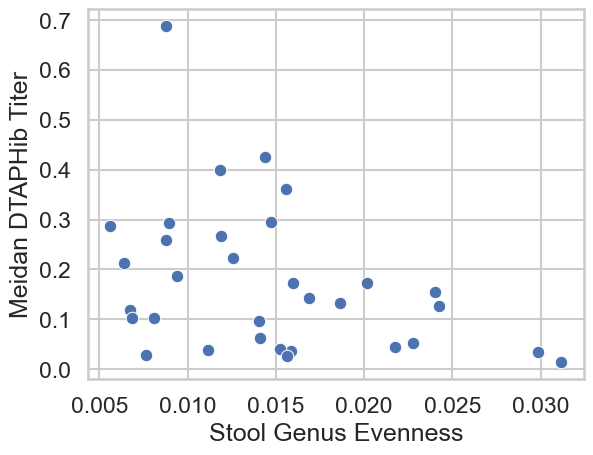

In [12]:
sns.scatterplot(x='genus_evenness',
                y='median_mmNorm_DTAPHib',
                data=stool_meta.query("VisitCode == 'V5'"))
plt.xlabel('Stool Genus Evenness')
plt.ylabel('Meidan DTAPHib Titer')

## Combined analysis

In [13]:
titer_stats = pd.concat([nasal_titer_stats, stool_titer_stats]).sort_values('p_value')

In [14]:
titer_stats.query('p_value < .05')

,body_site,timepoint,div_metric,titer_measure,N_LVR,N_NVR,N,stat,R,p_value
145,nasal,V8,MDS1,median_mmNorm_DTAPHib,NaN,NaN,50.0,NaN,0.454801,0.000906
95,nasal,V9,simpson_e_div,median_mmNorm_PCV,NaN,NaN,55.0,NaN,-0.387002,0.003841
341,stool,V3,ko_richness,median_mmNorm_PCV,NaN,NaN,20.0,NaN,-0.556600,0.010806
303,stool,V2,genus_evenness,median_mmNorm,NaN,NaN,26.0,NaN,-0.478974,0.013302
339,stool,V3,ko_richness,median_mmNorm,NaN,NaN,20.0,NaN,-0.522001,0.018233
328,stool,V2,ko_MDS2,median_mmNorm_DTAPHib,NaN,NaN,26.0,NaN,-0.459145,0.018299
144,nasal,V8,MDS1,median_mmNorm,NaN,NaN,50.0,NaN,0.329268,0.019548
93,nasal,V9,simpson_e_div,median_mmNorm,NaN,NaN,55.0,NaN,-0.313894,0.02081
150,stool,V4,genus_richness,median_mmNorm,NaN,NaN,14.0,NaN,0.604396,0.022057
180,stool,V9,genus_richness,median_mmNorm,NaN,NaN,37.0,NaN,0.352104,0.032579


In [15]:
vaccine_times = ['V5', 'V6', 'V7', 'V9']
titer_stats_vax = titer_stats.query('timepoint in @vaccine_times').sort_values(['timepoint', 'div_metric', 'titer_measure'])
titer_stats_vax['p_adj'] = p_adjust(titer_stats_vax['p_value'])
titer_stats_vax = titer_stats_vax.sort_values('p_adj')
titer_stats_vax.query('p_value < .05')

,body_site,timepoint,div_metric,titer_measure,N_LVR,N_NVR,N,stat,R,p_value,p_adj
95,nasal,V9,simpson_e_div,median_mmNorm_PCV,NaN,NaN,55.0,NaN,-0.387002,0.003841,0.691446
199,stool,V9,kraken_MDS1,median_mmNorm_DTAPHib,NaN,NaN,37.0,NaN,0.342579,0.037933,0.976296
93,nasal,V9,simpson_e_div,median_mmNorm,NaN,NaN,55.0,NaN,-0.313894,0.02081,0.976296
180,stool,V9,genus_richness,median_mmNorm,NaN,NaN,37.0,NaN,0.352104,0.032579,0.976296
43,stool,V5,ko_evenness,median_mmNorm_DTAPHib,NaN,NaN,32.0,NaN,-0.354106,0.046769,0.976296
129,nasal,V6,MDS1,median_mmNorm,NaN,NaN,52.0,NaN,0.293825,0.045005,0.976296


In [16]:
vaccine_times = ['V5', 'V6', 'V7', 'V9']
titer_stats_vax_stool = titer_stats.query('timepoint in @vaccine_times and body_site == "stool"').sort_values(['timepoint', 'div_metric', 'titer_measure'])
titer_stats_vax_stool['p_adj'] = p_adjust(titer_stats_vax_stool['p_value'])
titer_stats_vax_stool = titer_stats_vax_stool.sort_values('p_adj')
titer_stats_vax_stool.query('p_value < .05')

,body_site,timepoint,div_metric,titer_measure,N_LVR,N_NVR,N,stat,R,p_value,p_adj
199,stool,V9,kraken_MDS1,median_mmNorm_DTAPHib,NaN,NaN,37.0,NaN,0.342579,0.037933,0.942978
180,stool,V9,genus_richness,median_mmNorm,NaN,NaN,37.0,NaN,0.352104,0.032579,0.942978
43,stool,V5,ko_evenness,median_mmNorm_DTAPHib,NaN,NaN,32.0,NaN,-0.354106,0.046769,0.942978
